<a href="https://colab.research.google.com/github/SumedhGanpatye/Face-Recognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import Dataset , DataLoader
from numpy.random import Generator, SFC64
from torch.utils.data import Dataset , DataLoader


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32,9)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 9)
        self.fc1 = nn.Linear(64 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 16)
    def forward(self, x,y):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 10 * 10)#flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        y = self.pool(torch.relu(self.conv1(y)))
        y = self.pool(torch.relu(self.conv2(y)))
        y = y.view(-1, 64 * 10 * 10)#flatten
        y = torch.relu(self.fc1(y))
        y = torch.relu(self.fc2(y))
        y = self.fc3(y)
        return x,y

net = Net()

In [ ]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=3.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive.to(device)

In [ ]:
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.91, 0.999))
criterion = ContrastiveLoss()

In [ ]:

class OlivettiFaces(Dataset):
  def __init__(self, data_path='/content/Data'):
    (self.data, self.target) = fetch_olivetti_faces(data_home=data_path, shuffle=False, download_if_missing=True, return_X_y=True)

  def __len__(self):
    return len(self.target)

  def __getitem__(self, index):
    if index%2 == 0:
      idx = rng.integers(low=index-index%10, high=index-index%10+10)
      img1 = self.data[idx].reshape(1,64,64)
      img2 = self.data[index].reshape(1,64,64)
      return (torch.from_numpy(img1), torch.from_numpy(img2), torch.tensor(0, dtype=torch.float32))
    else:
      idx = rng.integers(low=0, high=400)
      while (idx >= index-index%10 and idx <= index-index%10+10):
        idx = rng.integers(low=0, high=400)
      img1 = self.data[idx].reshape(1,64,64)
      img2 = self.data[index].reshape(1,64,64)
      return (torch.from_numpy(img1), torch.from_numpy(img2), torch.tensor(1, dtype=torch.float32))

In [ ]:
rng=Generator(SFC64(12345))

In [ ]:
Data_loader = OlivettiFaces()  # tuple of image and target
train_loader=torch.utils.data.DataLoader(Data_loader,batch_size = 32,shuffle=False)

In [ ]:
net = net.to(device)

In [ ]:
losses = []  # Initialize losses as an empty list
num_epochs = 100

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        img1, img2, label = data
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = net(img1, img2)
        output1 = output1.to(device)
        output2 = output2.to(device)

        loss = criterion(output1, output2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if(epoch%10==0):
      print(f"Epoch {epoch + 1}, Loss: {loss}")


Epoch 1, Loss: 2.475222110748291
Epoch 11, Loss: 0.42002880573272705
Epoch 21, Loss: 0.5194869041442871
Epoch 31, Loss: 0.6178809404373169
Epoch 41, Loss: 0.3210163116455078
Epoch 51, Loss: 0.20785363018512726
Epoch 61, Loss: 0.20153963565826416
Epoch 71, Loss: 0.09808020293712616
Epoch 81, Loss: 0.048890940845012665
Epoch 91, Loss: 0.08757974952459335


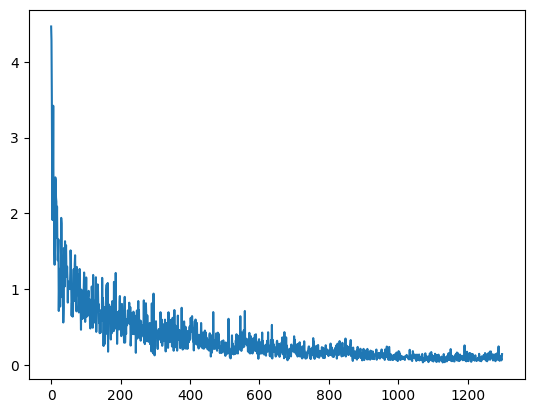

In [ ]:
plt.plot(losses)
plt.show()
#100 epochs

In [ ]:
test_loader=torch.utils.data.DataLoader(Data_loader,batch_size = 400,shuffle=True)

In [ ]:
correct=0
epoches=399
for i,data in enumerate(test_loader,0):
  img1, img2, label = data
  img1, img2, label = img1.to(device), img2.to(device), label.to(device)

for j in range(epoches):
    image1=img1[j].unsqueeze(0)
    image2=img2[j].unsqueeze(0)
    output1, output2 = net(image1, image2)
    output1 = output1.to(device)
    output2 = output2.to(device)
    loss=torch.sum(abs(output1-output2))
    if(loss<3.0 and label[j]==0):
      correct=correct+1
    elif(loss>3.0 and label[j]==1):
      correct=correct+1


In [ ]:
print(correct*100/epoches)

99.49874686716792
